# Tutorial: Differentiable Information Imbalance

The Differentiable Information Imbalance (DII) is implemented in the 'FeatureWeighting' class. To see all the functions that you can call within this class, please refer to: ????

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations_with_replacement

from dadapy.metric_comparisons import MetricComparisons
from dadapy.feature_weighting import FeatureWeighting

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Comparison with the standard Information Imbalance

In this section we show how to compute the differentiable Information Imbalance,
\begin{equation}
    DII(A\rightarrow B) = \frac{2}{N^2} \sum_{i,j=1}^N\, c_{ij}^A\, r_{ij}^B\, \hspace{1cm} \Bigg( c_{ij}^A = \frac{\exp(-d_{ij}^A/\lambda)}{\sum_{k(\neq i)}{\exp(-d_{ik}^A/\lambda)}}\Bigg),
\end{equation}
for different choices of the parameter $\lambda$, and we see that the differentiable version tends to the standard Information Imbalance in the limit of small $\lambda$. We will define the distance spaces A and B using subsets of coordinates from a isotropic 3D Gaussian distribution.

### Included methods:
- Prediction of distance space B from distance space A for a given value of $\lambda$: return_dii

In [3]:
# sample dataset
N = 1000
cov = np.identity(3)
mean = np.zeros(3)
np.random.seed(9)
X = np.random.multivariate_normal(mean=mean, cov=cov, size=(N))

# define spaces A and B by subsets of coordinates
coords1 = [0, 1]
coords2 = [0, 1, 2]

In [4]:
# define an instance of the FeatureWeighting class
f = FeatureWeighting(coordinates=X[:, coords1])
f_target = FeatureWeighting(coordinates=X[:, coords2])

diff_imbs = []
lambdas = np.logspace(-7, -1, 10)  # uniformly spaced in [1e-7, 1e-1] in log scale
for lambd in lambdas:
    diff_imbs.append(f.return_dii(target_data=f_target, lambd=lambd))

/var/folders/gs/c6kntl8s5z7b8jcdsd9xydww0000gp/T/ipykernel_64904/1281833669.py:8: UserWarning: maxk option not yet available for the FeatureWeighting class. It will be set to the number of data-1 (1000-1).
  diff_imbs.append(f.return_dii(target_data=f_target, lambd=lambd))


We compute for comparison purposes the standard Information Imbalance between the same distance spaces:

In [5]:
# define an instance of the MetricComparisons class
d = MetricComparisons(X, maxk=N - 1)
imbs = d.return_inf_imb_two_selected_coords(coords1=coords1, coords2=coords2)

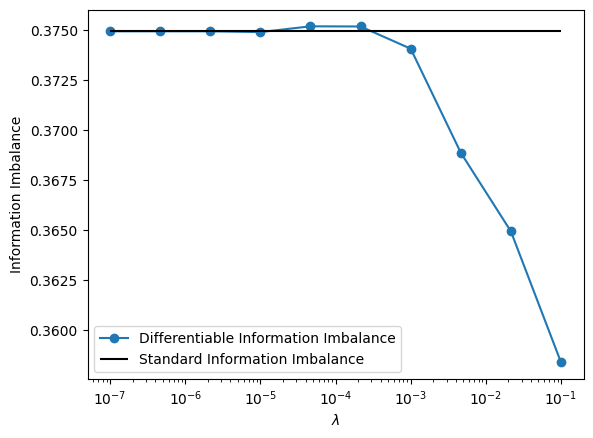

In [6]:
plt.plot(lambdas, diff_imbs, "o-", label="Differentiable Information Imbalance")
plt.hlines(
    imbs[0],
    lambdas[0],
    lambdas[-1],
    color="black",
    label="Standard Information Imbalance",
)
plt.xscale("log")
plt.xlabel("$\\lambda$")
plt.ylabel("Information Imbalance")
plt.legend()
plt.show()

## Optimization on a 10D anisotropic Gaussian dataset

In this example we show how to optimize the weights $\{w_\alpha\}$ of the features $\{X_\alpha\}$ in a space A $(\alpha=1,...,D)$, appearing in the distance function as
\begin{equation}
    d_{ij}^A(\{w_\alpha\}) = \Bigg[\sum_{\alpha=1}^D\,(X_\alpha^i - X_\alpha^j) \Bigg]^{1/2},
\end{equation}
in order to optimize the prediction of the distances measured in a target space B. We will construct space A using a 10D isotropic Gaussian distribution, and space B by reweighting its coordinates, resulting in a 10D anisotropic Gaussian.

### Included methods:
- Batch gradient-descent optimization of the DII with respect to weights of features in space A, given a target distance space B: return_weights_optimize_dii

In [7]:
# sample datasets
N = 500  # number of points
d = 10  # dimension

cov = np.identity(10)
mean = np.zeros(10)
X = np.random.multivariate_normal(mean=mean, cov=cov, size=(N))  # isotropic Gaussian

weights = np.ones(10) * (0.01**2)
weights[0:5] = [5, 2, 1, 1, 0.5]
X_target = X * weights  # target space B constructed on this anisotropic Gaussian

The following block carries out the optimization:

In [8]:
initial_weights = np.ones(10)  # starting weights in the optimization
n_epochs = 200  # number of training epochs

f = FeatureWeighting(coordinates=X)
f_target = FeatureWeighting(coordinates=X_target)
final_weights = f.return_weights_optimize_dii(
    target_data=f_target,
    initial_weights=initial_weights,
    n_epochs=n_epochs,
    decaying_lr=False,
)

/var/folders/gs/c6kntl8s5z7b8jcdsd9xydww0000gp/T/ipykernel_64904/3101833307.py:6: UserWarning: maxk option not yet available for the FeatureWeighting class. It will be set to the number of data-1 (500-1).
  final_weights = f.return_weights_optimize_dii(


If the arguments 'lambd' and 'learning_rate' are not specified, these parameters are set automatically. By default, the optimization is carried out using an exponentially decay scheme for the learning rate; this feature can be disabled by setting 'decaying_lr=False'. After the optimization the FeatureWeighting object allows to access the values of the DII and the weights during the training:

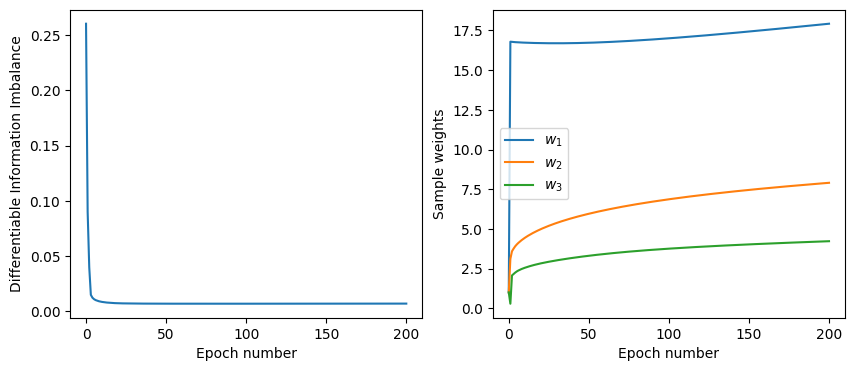

In [9]:
dii_per_epoch = f.history["dii_per_epoch"]
weights_per_epoch = f.history["weights_per_epoch"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(np.arange(n_epochs + 1), dii_per_epoch)
ax2.plot(np.arange(n_epochs + 1), weights_per_epoch[:, 0], label="$w_1$")
ax2.plot(np.arange(n_epochs + 1), weights_per_epoch[:, 1], label="$w_2$")
ax2.plot(np.arange(n_epochs + 1), weights_per_epoch[:, 2], label="$w_3$")

ax1.set(ylabel="Differentiable Information Imbalance", xlabel="Epoch number")
ax2.set(ylabel="Sample weights", xlabel="Epoch number")
ax2.legend()
plt.show()

We can visually compare the ground-truth weights of the anisotropic 10D Gaussian (i.e. the marginal standard deviations of the coordinates) and the optimal weights obtained from the optimization, after scaling them in the range [0,1]:

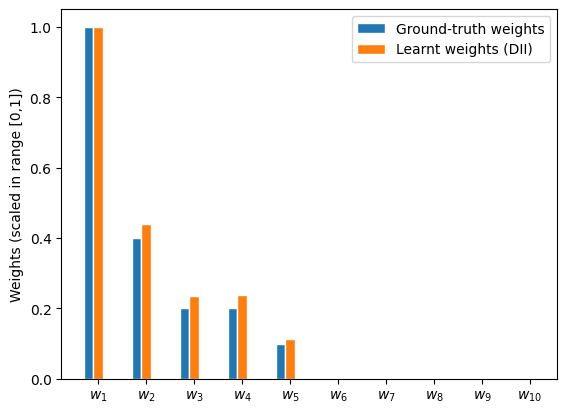

In [10]:
weights_names = ("$w_1$","$w_2$","$w_3$","$w_4$","$w_5$",
                 "$w_6$","$w_7$","$w_8$","$w_9$","$w_{10}$")
weights_grouped = {
    "Ground-truth weights": weights / max(weights),
    "Learnt weights (DII)": final_weights / max(final_weights),
}

x = np.arange(len(weights_names))  # label locations
width = 0.2  # bar widths
multiplier = 0

fig, ax = plt.subplots()
for attribute, measurement in weights_grouped.items():
    offset = width * multiplier
    ax.bar(x + offset, measurement, width, label=attribute, edgecolor="white")
    multiplier += 1

ax.set_ylabel("Weights (scaled in range [0,1])")
ax.set_xticks(x + width, weights_names)
ax.legend()
plt.show()

From the bar plot above we see that the scaled weights reproduce well the target standard deviations of the anisotropic Gaussian distribution

## Backward greedy elimination 

In this example we illustrate how to carry out a backward greedy elimination where, given a target space B and a starting set of $D$ candidate features in space A, all the optimal subsets of $D' (\leq D)$ features to predict B are identified. At each step, the weights of the candidate features are optimized by minimizing the DII to the target space B, and after each optimization the feature associated to the lowest weight is discarded. The search stops when the optimal subset with a single feature is identified.

We will employ for space A 65 candidate features, given by all the monomials of degree up to 2 obtained from a set of 10 independent Gaussian features of zero mean and unit variance ($x_i \sim \mathcal{N}(0,1)$):
\begin{equation}
    \underbrace{x_1, x_2, ...}_{\text{order 1}},\, 
    \underbrace{x_1^2, x_2^2, ..., x_1\,x_2,\, x_1\,x_3, ...}_{\text{order 2}}\,.
\end{equation}
The target distance B is constructed by selecting with different weights only 10 of the 65 monomials.

### Included methods:
- Stepwise backward greedy elimination: return_backward_greedy_dii_elimination

In [11]:
# create all subsets of 10 elements with cardinality 1 or 2
ncoords = range(10)
monomials_list = []
for degree in [1, 2]:
    monomials_list += list(combinations_with_replacement(ncoords, degree))

# use subsets to construct all possible monomials up to degree 2
X_monomials = np.empty((X.shape[0], len(monomials_list)))
for i_monomial, coords in enumerate(monomials_list):
    monomial = np.prod(X[:, coords], axis=1)
    X_monomials[:, i_monomial] = monomial

In [12]:
# construct the target space B by selecting 10 monomials with different weights
monomials_target = [5, 8, 12, 14, 20, 26, 35, 47, 59, 61]
weights = np.zeros(len(monomials_list))
weights[monomials_target] = [5, 5, 7, 2, 1, 4, 1.5, 1, 3, 6]

coords_names = np.array(
    ["X_1", "X_2", "X_3", "X_4", "X_5", "X_6", "X_7", "X_8", "X_9", "X_{10}"]
)
print("Selected monomials in target space B:")
for monomial_index in monomials_target:
    monomial = monomials_list[monomial_index]
    print(f"\t{coords_names[list(monomial)]} with weight {weights[monomial_index]}")

X_monomials_target = X_monomials * weights

Selected monomials in target space B:
	['X_6'] with weight 5.0
	['X_9'] with weight 5.0
	['X_1' 'X_3'] with weight 7.0
	['X_1' 'X_5'] with weight 2.0
	['X_2' 'X_2'] with weight 1.0
	['X_2' 'X_8'] with weight 4.0
	['X_3' 'X_9'] with weight 1.5
	['X_5' 'X_8'] with weight 1.0
	['X_8' 'X_8'] with weight 3.0
	['X_8' 'X_{10}'] with weight 6.0


The following block carries out the backward elimination starting from the whole space of the 65 features (monomials) in space A. Its execution requires a few minutes; the progression state can be monitored by setting verbose=True when the FeatureWeighting object is initialized.

In [14]:
initial_weights = np.ones(len(monomials_list))  # starting weights in the optimization
n_epochs = 100  # number of training epochs

f = FeatureWeighting(coordinates=X_monomials, verbose=False)
f_target = FeatureWeighting(coordinates=X_monomials_target)

final_imbs, final_weights = f.return_backward_greedy_dii_elimination(
    target_data=f_target,
    initial_weights=initial_weights,
    n_epochs=n_epochs,
    learning_rate=None,  # set automatically
    decaying_lr=False,
)

/var/folders/gs/c6kntl8s5z7b8jcdsd9xydww0000gp/T/ipykernel_64904/59226479.py:7: UserWarning: maxk option not yet available for the FeatureWeighting class. It will be set to the number of data-1 (500-1).
  final_imbs, final_weights = f.return_backward_greedy_dii_elimination(


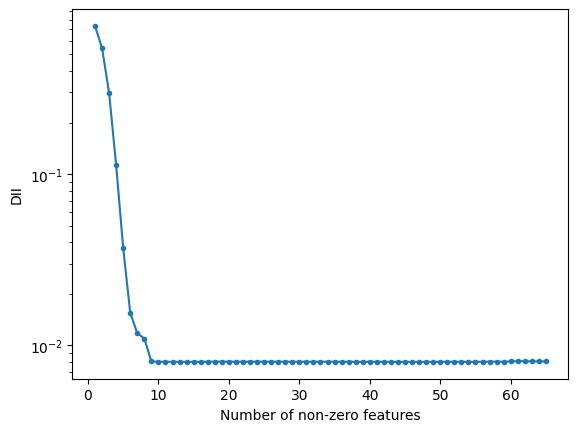

In [ ]:
# optimized information imbalance vs number of non-zero features
plt.plot(np.arange(X_monomials.shape[1], 0, -1), final_imbs, ".-")
plt.xlabel("Number of non-zero features")
plt.ylabel("DII")
plt.yscale("log")
plt.show()

From the plot above we see that the optimized DII reaches a plateau after 9-10 features, which is consistent with the numbers of monomials included in the target space B. We can further verify that, for the subset with 10 non-zero features, both the selected features and their weights are consistent with the ground-truth ones:

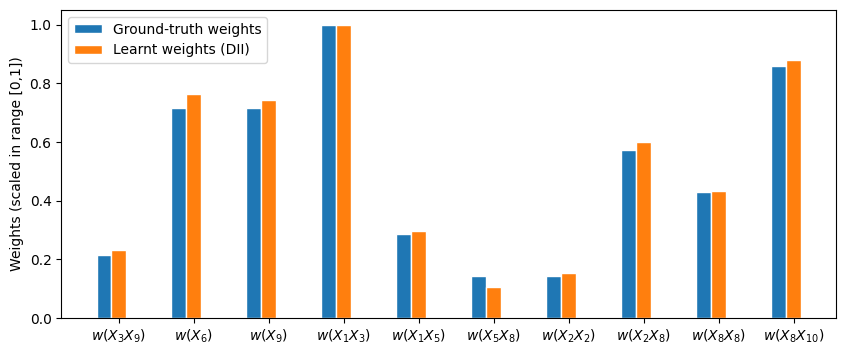

In [ ]:
n_subset = 10
monomials_learnt = np.where(final_weights[-n_subset] > 0)[0]
union_set = list(set(monomials_target).union(monomials_learnt))

weights_grouped = {
    "Ground-truth weights": weights[union_set] / max(weights[union_set]),
    "Learnt weights (DII)": final_weights[-n_subset][union_set]
    / max(final_weights[-n_subset][union_set]),
}
weights_names = []
for monomial_index in union_set:
    monomial = monomials_list[monomial_index]
    weights_names.append(f"$w({''.join((coords_names[list(monomial)]))})$")

x = np.arange(len(weights_names))  # label locations
width = 0.2  # bar widths
multiplier = 0
fig, ax = plt.subplots(figsize=(10, 4))
for attribute, measurement in weights_grouped.items():
    offset = width * multiplier
    ax.bar(x + offset, measurement, width, label=attribute, edgecolor="white")
    multiplier += 1
ax.set_ylabel("Weights (scaled in range [0,1])")
ax.set_xticks(x + width, weights_names)
ax.legend()
plt.show()

## L1-regularized search of optimal features

In this section we show how to carry out a selection of optimal subsets of features in space A in order to predict a target space B, by optimizing the Differentiable Information Imbalance with a lasso (L1) regularization. Explicitely, the loss function which is minimized is
\begin{equation}
    \mathcal{L} = DII(A(\{w_\alpha\})\rightarrow B) + \beta \sum_{\alpha=1}^D\, |w_\alpha |\,,
\end{equation}
where $\beta$ is the strength of the regularization, which determines the number of non-zero weights. To identify subsets with different numbers of non-zero features, a scan over different values of $\beta$ is required.

We will use the same dataset of monomials employed in the previous example.

### Included methods:
- Search of optimal subsets of features by optimizing the DII with different strengths of the L1 regularization term : return_lasso_optimization_dii_search

In [ ]:
# create all subsets of 10 elements with cardinality 1 or 2
ncoords = range(10)
monomials_list = []
for degree in [1, 2]:
    monomials_list += list(combinations_with_replacement(ncoords, degree))

# use subsets to construct all possible monomials up to degree 2
X_monomials = np.empty((X.shape[0], len(monomials_list)))
for i_monomial, coords in enumerate(monomials_list):
    monomial = np.prod(X[:, coords], axis=1)
    X_monomials[:, i_monomial] = monomial

In [ ]:
# construct space B by selecting 10 monomials with different weights
monomials_target = [5, 8, 12, 14, 20, 26, 35, 47, 59, 61]
weights = np.zeros(len(monomials_list))
weights[monomials_target] = [5, 5, 7, 2, 1, 4, 1.5, 1, 3, 6]

coords_names = np.array(
    ["X_1", "X_2", "X_3", "X_4", "X_5", "X_6", "X_7", "X_8", "X_9", "X_{10}"]
)
print("Selected monomials in target space B:")
for monomial_index in monomials_target:
    monomial = monomials_list[monomial_index]
    print(f"\t{coords_names[list(monomial)]} with weight {weights[monomial_index]}")

X_monomials_target = X_monomials * weights

Selected monomials in target space B:
	['X_6'] with weight 5.0
	['X_9'] with weight 5.0
	['X_1' 'X_3'] with weight 7.0
	['X_1' 'X_5'] with weight 2.0
	['X_2' 'X_2'] with weight 1.0
	['X_2' 'X_8'] with weight 4.0
	['X_3' 'X_9'] with weight 1.5
	['X_5' 'X_8'] with weight 1.0
	['X_8' 'X_8'] with weight 3.0
	['X_8' 'X_{10}'] with weight 6.0


The following block optimizes the DII(A\rightarrow B) with a lasso regularization. By default, 10 optimizations for different values of the regularization strength $\beta$ are carried out. If 'refine=True', additional values of $\beta$ are tested in order to identify more subsets with a different number of non-zero features. Specific values of the parameters $\beta$ to be tested can be set by the user with the argument 'l1_penalties'. As in the greedy search algorithm, the progress of the optimization can be monitored by setting verbose=True.

/var/folders/gs/c6kntl8s5z7b8jcdsd9xydww0000gp/T/ipykernel_58933/3865090392.py:12: UserWarning: maxk option not yet available for the FeatureWeighting class. It will be set to the number of data-1 (500-1).
  ) = f.return_lasso_optimization_dii_search(


10 l1-penalties to test:
optimization with l1-penalty 1 of strength 0 took: 8.90 s.
optimization with l1-penalty 2 of strength 1e-06 took: 8.40 s.
optimization with l1-penalty 3 of strength 3.162e-06 took: 8.02 s.
optimization with l1-penalty 4 of strength 1e-05 took: 7.21 s.
optimization with l1-penalty 5 of strength 3.162e-05 took: 6.01 s.
optimization with l1-penalty 6 of strength 0.0001 took: 4.45 s.
optimization with l1-penalty 7 of strength 0.0003162 took: 3.54 s.
optimization with l1-penalty 8 of strength 0.001 took: 2.94 s.
optimization with l1-penalty 9 of strength 0.003162 took: 2.22 s.


/Users/vdeltatt/opt/anaconda3/envs/dadapy_dev/lib/python3.8/site-packages/dadapy/_utils/differentiable_imbalance.py:529: UserWarning: The l1-regularization of 0.01 is too high. All features would be set to 0. No full optimization possible
  warn(


optimization with l1-penalty 10 of strength 0.01 took: 0.40 s.


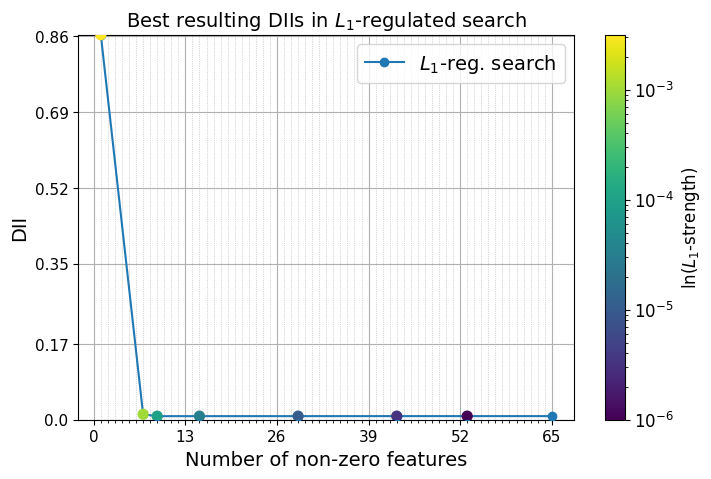

In [ ]:
initial_weights = np.ones(len(monomials_list))  # starting weights in the optimization
n_epochs = 100  # number of training epochs

f = FeatureWeighting(coordinates=X_monomials, verbose=False)
f_target = FeatureWeighting(coordinates=X_monomials_target)

(
    num_nonzero_features,
    l1_penalties_opt_per_nfeatures,
    dii_opt_per_nfeatures,
    weights_opt_per_nfeatures,
) = f.return_lasso_optimization_dii_search(
    target_data=f_target,
    initial_weights=initial_weights,
    n_epochs=n_epochs,
    learning_rate=None,  # set automatically
    decaying_lr=False,
    refine=False,  # only 10 values of the L1 strength are tested
    plotlasso=True,  # automatically show DII vs number of non-zero features
)

The plot above shows the optimized DII reaches a pleateau after ~10 non-zero features. We can compare the optimal features identified in this set and their weights with the ground-truth values used to build the target space B:

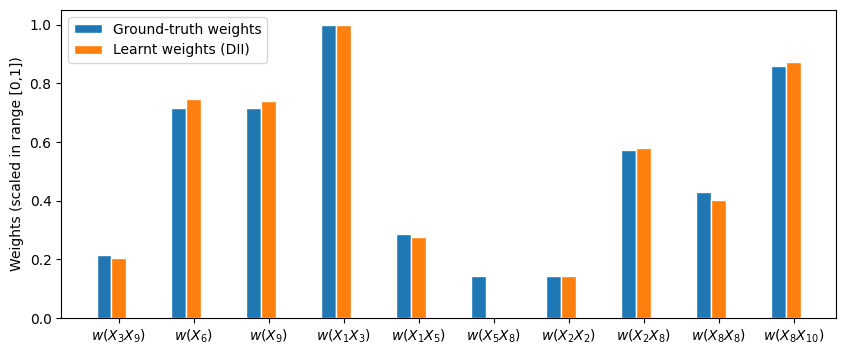

In [ ]:
# find number of non-zero features closest to 10 (ground-truth)
n_subset = len(monomials_list) - np.nanargmin(np.abs(10 - num_nonzero_features))
monomials_learnt = np.where(final_weights[-n_subset] > 1e-2)[0]
union_set = list(set(monomials_target).union(monomials_learnt))

weights_grouped = {
    "Ground-truth weights": weights[union_set] / max(weights[union_set]),
    "Learnt weights (DII)": weights_opt_per_nfeatures[-n_subset][union_set]
    / max(weights_opt_per_nfeatures[-n_subset][union_set]),
}
weights_names = []
for monomial_index in union_set:
    monomial = monomials_list[monomial_index]
    weights_names.append(f"$w({''.join((coords_names[list(monomial)]))})$")

x = np.arange(len(weights_names))  # label locations
width = 0.2  # bar widths
multiplier = 0
fig, ax = plt.subplots(figsize=(10, 4))
for attribute, measurement in weights_grouped.items():
    offset = width * multiplier
    ax.bar(x + offset, measurement, width, label=attribute, edgecolor="white")
    multiplier += 1
ax.set_ylabel("Weights (scaled in range [0,1])")
ax.set_xticks(x + width, weights_names)
ax.legend()
plt.show()